Another attempt at Ensemble regression using a more recent example...

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statistics as st
import warnings
import matplotlib.pyplot as plt 

warnings.filterwarnings('ignore')







In [2]:
# SPLITTING THE DATASET
target_path = '/kaggle/input/abalone/train.csv'
submission_path = '/kaggle/input/abalone/test.csv'

target = pd.read_csv(target_path)
submission = pd.read_csv(submission_path)

In [3]:
# One-hot encode 'Sex'
target = pd.get_dummies(target, columns=['Sex'], drop_first=True)
submission = pd.get_dummies(submission, columns=['Sex'], drop_first=True)

In [4]:
# View the updated dataset
target.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,False,False
1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,False,False
2,2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,True,False
3,3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,True
4,4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,True,False


In [5]:
x = target.drop('Rings', axis = 1)
y = target['Rings']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [7]:
# MODELS CREATION
dtmodel = DecisionTreeRegressor()
knmodel = KNeighborsRegressor()
lrmodel= LinearRegression()

dtmodel.fit(x_train,y_train)
knmodel.fit(x_train,y_train)
lrmodel.fit(x_train,y_train)


LinearRegression()

In [8]:
# PREDICTION
pred1=dtmodel.predict(x_test)
pred2=knmodel.predict(x_test)
pred3=lrmodel.predict(x_test)


In [9]:
len(pred2)

18123

Note that previous versions of this code, which were using Classifiers, used LogisticRegression.  This is a classifier, not a regressor, despite its name.

In [10]:
models = [{"predictions": pred1, "model": dtmodel, "name": "Decision Tree"}, 
          {"predictions": pred2, "model": knmodel, "name": "K Neighbors"},
          {"predictions": pred3, "model": lrmodel, "name": "Linear Regression"},
         ]
models[0]

{'predictions': array([ 5.,  8.,  9., ..., 11.,  6.,  8.]),
 'model': DecisionTreeRegressor(),
 'name': 'Decision Tree'}

In [11]:
pred3[:20]

array([ 7.10820247,  6.93512552,  8.40471328,  9.80915189,  9.09349532,
        8.7135917 , 10.32857452, 11.55892973, 12.56937706,  9.55060408,
        5.91394567,  5.67336775,  6.75981962,  8.71208794,  9.87829297,
        5.73369253, 13.67230021,  6.09967048, 10.71992044, 12.82574066])

In [12]:
def plot_predictions(models, sample_size=10):
    x = [n for n in range(sample_size)]

    plt.figure(figsize=(10, 6))

    # plot line
    for model in models:  
        plt.plot(x, model['predictions'][:sample_size], label=model['name'])

    plt.legend()
    plt.show()

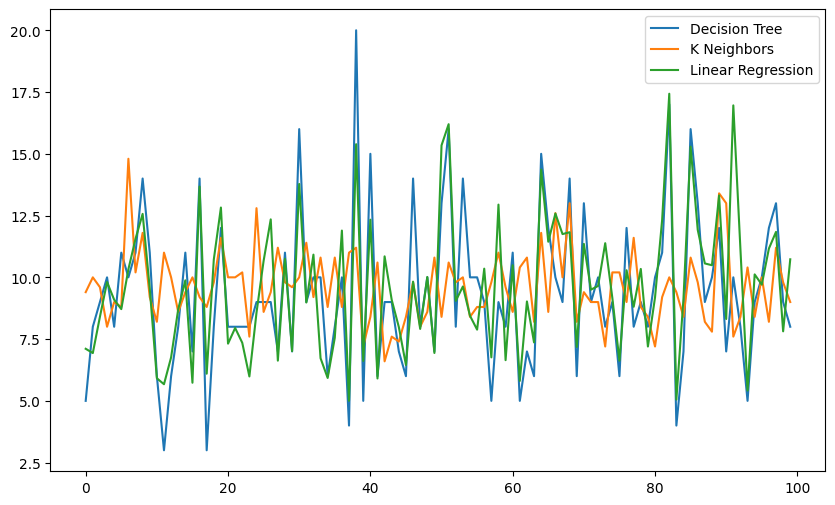

In [ ]:
plot_predictions(models, 100)

In [14]:
# FINAL_PREDICTION
final_pred = np.array([])
for i in range(0,len(x_test)):
    final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))
print(final_pred)

[ 5.  8.  9. ... 11.  6.  8.]


In [15]:
len(final_pred)

18123

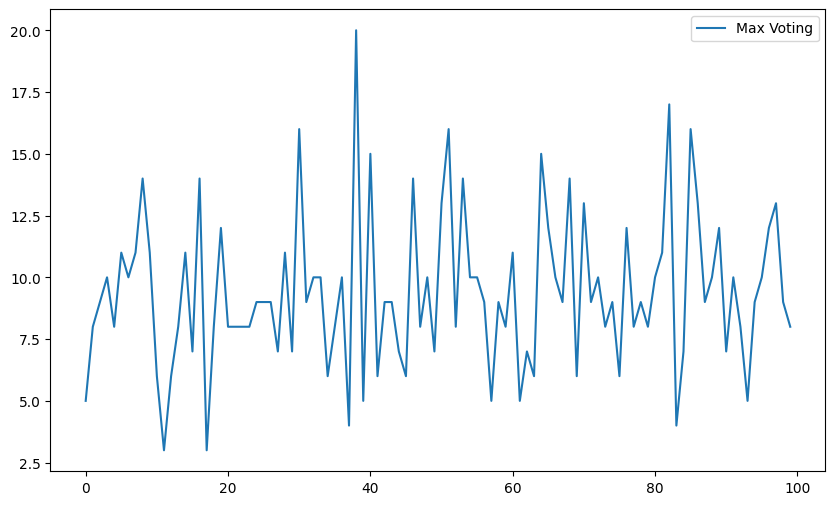

In [16]:
final_model1 = [{"predictions": final_pred, "name": "Max Voting"} ]
plot_predictions(final_model1, 100)

In [ ]:
combo1 = models + final_model1
plot_predictions(combo1, 100)

In [18]:
models[0]['predictions']

array([ 5.,  8.,  9., ..., 11.,  6.,  8.])

In [19]:
from sklearn.ensemble import VotingRegressor


vcmodel = VotingRegressor(estimators=[('dt', models[0]["model"]), 
                                      ('kn', models[1]["model"]), 
                                      ('lr', models[2]["model"])])
vcmodel.fit(x_train,y_train)
vcmodel.score(x_test,y_test)

0.5152814916480222

Now trying averaging:

In [20]:
#total = []
#for model in models:
#    pred = model['model'].predict_proba(x_test)
#    if (len(total) == 0):
#        total = pred
#    else:
#        total += pred


#finalpreda=(total)/3

Note how this does not really work, as the probabilities returned are a distribution, not a single value:
https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [21]:
#final_model1a = [{"predictions": finalpreda, "model": vcmodel, "name": "Averaging"} ]
#plot_predictions(final_model1a, 100)

Introducing the evaluations and code used in my previous submission
https://github.com/flyinacres/kaggle/blob/main/abalone-submission-01.ipynb

In [22]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [23]:
def identify_negatives(predictions):
    n = [num for num in predictions if num < 0]
    print(n)

In [24]:
def ceil_predictions(predictions):
    return [0.0001 if num < 0 else num for num in predictions]


In [25]:
# Need to ensure that results don't contain negative numbers or 0, or log will not work.
n = [0.0001 if num < 0 else num for num in models[2]['predictions']]
#print(n)

In [26]:
from sklearn.metrics import r2_score

def evaluate_model(true, predicted):
    # mae = mean_absolute_error(true, predicted)
    # mse = mean_squared_error(true, predicted)
    # rmse = np.sqrt(mean_squared_error(true, predicted))
    predicted = ceil_predictions(predicted)
    r2_square = r2_score(true, predicted)
    rmsle = root_mean_squared_log_error(true, predicted)
    return r2_square,rmsle 

Pretty poor results as such...  Not worth submitting

In [27]:
for model in models:
    pred = model['model'].predict(x_test)
    print(evaluate_model(y_test, pred))

(0.28915776493419043, 0.21618751133904066)
(-0.16121687329383527, 0.3110966611528479)
(0.6107223774586408, 0.1651925987148862)


Let's see if I can improve either of the first two estimators by using an automated parameter search function

https://scikit-learn.org/1.5/modules/grid_search.html

In [29]:
# Hyper parameters range intialization for tuning a decision tree

param_grid={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [33]:
# Try the Halving Grid to see if I can get some better parameters

# This line must come before the import.
# The noqa tells linters to ignore what appears to be an unused import
from sklearn.experimental import enable_halving_search_cv #noqa
from sklearn.model_selection import HalvingGridSearchCV

halving_grid = HalvingGridSearchCV(models[0].model, param_grid, cv=5)
halving_grid.fit(X_train, y_train)

print(halving_grid.best_params_)
print(halving_grid.best_score_)

AttributeError: 'dict' object has no attribute 'model'

In [ ]:
# See how well max voting stands up
print(evaluate_model(y_test, final_pred))

Now try doing some feature engineering first...

Determining the importance of features using example given in this code:
https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/#google_vignette

In [ ]:
# Feature selection by ExtraTreesRegressor(model based)

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

In [ ]:
reg= ExtraTreesRegressor()

In [ ]:
reg.fit(x_train,y_train)

In [ ]:
reg.feature_importances_

Note that running fit() with the Extras Trees Regressor can return some slightly different values when run multiple time...

array([0.04249536, 0.10284245, 0.07537722, 0.06437175, 0.10718521,
       0.12491027, 0.09111516, 0.25657742, 0.12073541, 0.01438977])

In [ ]:
feat_importances = pd.Series(reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
selected_features = ['Shell weight', 'Whole weight.1', 'Sex_I', 'Whole weight', 'Length', 'Whole weight.2', 'Diameter']

In [ ]:
print(selected_features)

In [49]:
x_train_selected = x_train[selected_features]
x_test_selected = x_test[selected_features]
x_train_selected

,Shell weight,Whole weight.1,Sex_I,Whole weight,Length,Whole weight.2,Diameter
38059,0.2265,0.3915,True,0.8915,0.580,0.1820,0.400
26114,0.1750,0.3155,False,0.7095,0.525,0.1455,0.405
19998,0.2635,0.4775,False,1.0185,0.625,0.2255,0.475
18162,0.3400,0.3675,False,1.0225,0.575,0.2155,0.450
56716,0.2350,0.2985,False,0.8270,0.570,0.2260,0.460
...,...,...,...,...,...,...,...
21243,0.0065,0.0080,True,0.0210,0.190,0.0065,0.170
45891,0.0350,0.0565,True,0.1365,0.275,0.0240,0.200
42613,0.1700,0.2645,False,0.5885,0.530,0.1415,0.415
43567,0.0850,0.1165,False,0.2665,0.405,0.0585,0.305


In [50]:
dtmodel.fit(x_train_selected,y_train)
knmodel.fit(x_train_selected,y_train)
lrmodel.fit(x_train_selected,y_train)


LinearRegression()

In [51]:
# PREDICTION
pred1=dtmodel.predict(x_test_selected)
pred2=knmodel.predict(x_test_selected)
pred3=lrmodel.predict(x_test_selected)


In [53]:
for model in models:
    pred = model['model'].predict(x_test_selected)
    print(evaluate_model(y_test, pred))

(0.30132210720015473, 0.21804231711009414)
(0.5988763864364282, 0.16549669431690262)
(0.6027446135762022, 0.16716702121724705)


Results without feature selection via ExtraTreesRegressor:

(0.2985121025497409, 0.2158039329633151)
(-0.16121687329383527, 0.3110966611528479)
(0.6107223774586408, 0.1651925987148862)

results with feature selection

(0.30132210720015473, 0.21804231711009414)
(0.5988763864364282, 0.16549669431690262)
(0.6027446135762022, 0.16716702121724705)

So the kneighbors substantiall improved but the others did not change much at all

Add the actual values in so that I can plot various solutions against the actuals...

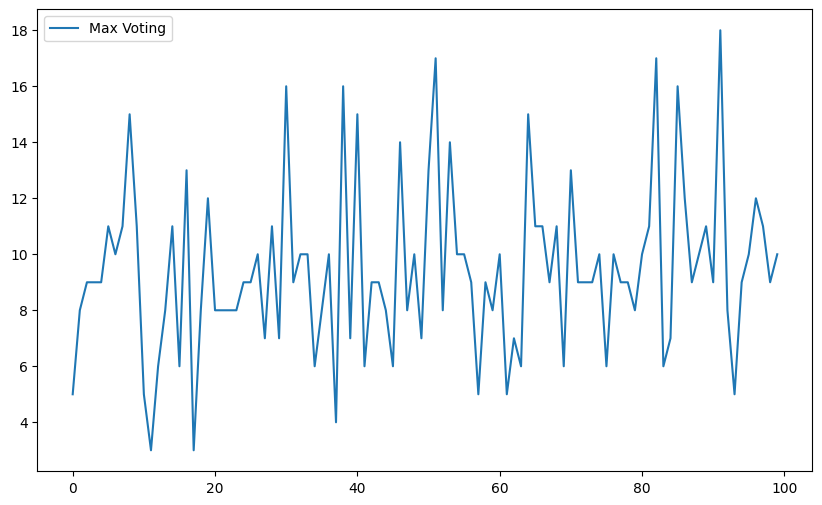

In [30]:
actual_preds = [{"predictions": y_test, "name": "Actual Values"} ]
plot_predictions(final_model1, 100)

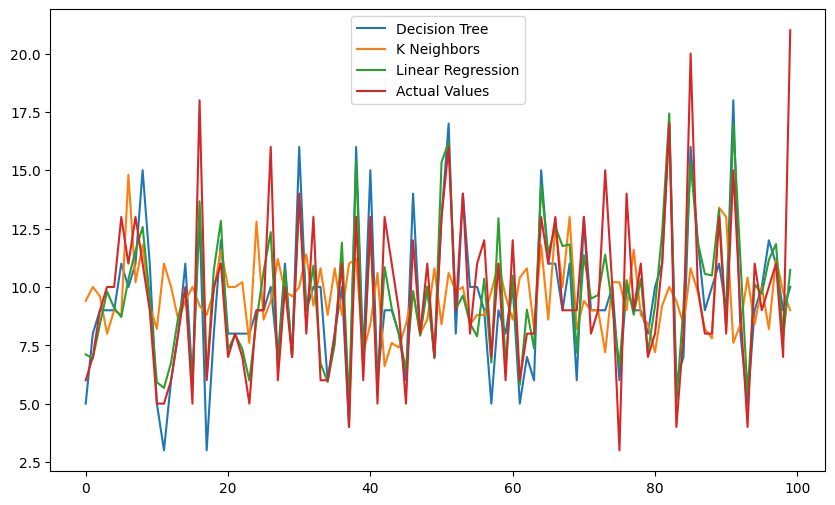

In [31]:
combo1 = models + actual_preds
plot_predictions(combo1, 100)

Too hard to pick out the individual results vs the actual.  I'll just pick the best:

In [32]:
type(models[2])

dict

In [33]:
print(actual_preds)

[{'predictions': 19402     6
2753      7
85629     9
7777     10
90199    10
         ..
12490    10
56089    11
74706    10
8166      8
38921     9
Name: Rings, Length: 18123, dtype: int64, 'name': 'Actual Values'}]


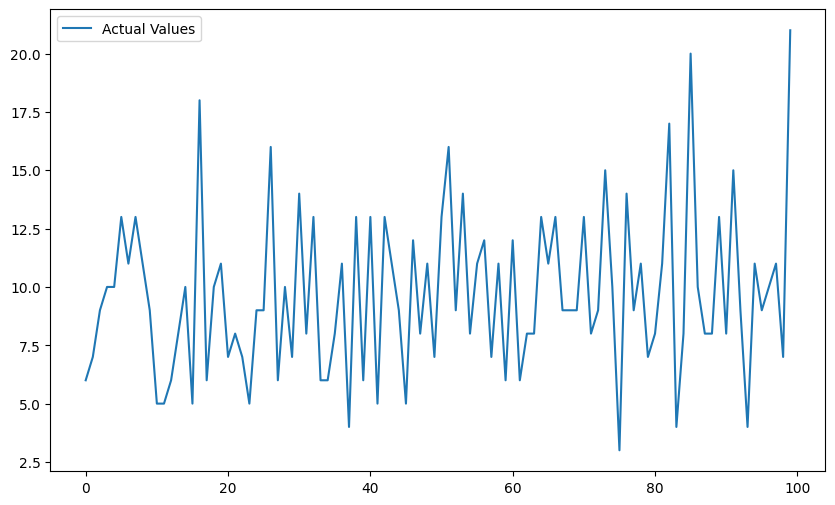

In [34]:
# huh, a rare destructive operation. After running this actual_preds has been changed...
#actual_preds.append(models[2])
#print(combo2)
plot_predictions(actual_preds, 100)

An attempt at Bagging

In [35]:
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
model = BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.6208221979527705

Now I have to look up and see if this is a good score... :)  Note that this appears to be almost identical to the linear regression score...

I can see my Kaggle Score at: https://www.kaggle.com/competitions/playground-series-s4e4/submissions

This is almost identical to the score I already submitted..

In [36]:
pred = model.predict(x_test)
print(evaluate_model(y_test, pred))

(0.6208221979527705, 0.16137066993711033)


1. Does my Bagging example actually consider all of my models?  Seems like it only looks at one. Once I have it working properly try it with the feature-selected versions
2. I have not yet implemented HalvingGridSearchCV.  I need to figure out which parameters for which regressors make sense to search on
3. Next I need to check AdaBoost and see if that has any benefit.